# ACTIVIDAD DE CLASIFICACIÓN DE TEXTO

En esta actividad vamos a trabajar en clasificar textos. Se recorrerá todo el proceso desde traer el dataset hasta proceder a dicha clasificación. Durante la actividad se llevarán a cabo muchos procesos como la creación de un vocabulario, el uso de embeddings y la creación de modelos.

Las cuestiones presentes en esta actividad están basadas en un Notebook creado por François Chollet, uno de los creadores de Keras y autor del libro "Deep Learning with Python".

En este Notebook se trabaja con el dataset "Newsgroup20" que contiene aproximadamente 20000 mensajes que pertenecen a 20 categorías diferentes.

El objetivo es entender los conceptos que se trabajan y ser capaz de hacer pequeñas experimentaciones para mejorar el Notebook creado.

# Librerías

In [102]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pathlib
import spacy
import en_core_web_sm
import pandas as pd
import json
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from tqdm import tqdm

In [36]:
nlp = en_core_web_sm.load()

# Descarga de Datos

In [2]:
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

In [3]:
#Estructura de directorios del dataset
data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

Number of directories: 20
Directory names: ['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']


<p>Vamos a almacenar los directorios en un diccionario donde la clave sea el nombre de cada categoría y el contenido el directorio donde se encuentran dichos datos, esto lo haremos porque nos será útil a la hora de hacer el entrenamiento.</p>

In [4]:
directorios = {dname: data_dir / dname for dname in dirnames}

In [5]:
directorios

{'talk.politics.mideast': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/talk.politics.mideast'),
 'rec.autos': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/rec.autos'),
 'comp.sys.mac.hardware': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/comp.sys.mac.hardware'),
 'alt.atheism': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/alt.atheism'),
 'rec.sport.baseball': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/rec.sport.baseball'),
 'comp.os.ms-windows.misc': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/comp.os.ms-windows.misc'),
 'rec.sport.hockey': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/rec.sport.hockey'),
 'sci.crypt': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/sci.crypt'),
 'sci.med': PosixPath('/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup/sci.med'),
 

In [6]:
print(data_dir)

/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup


In [7]:
data_dir_graphics = directorios["comp.graphics"]

In [55]:
#Algunos archivos de la categoria "com.graphics"
fnames = os.listdir(data_dir_graphics)
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of files in comp.graphics: 1000
Some example filenames: ['38254', '38402', '38630', '38865', '38891']


In [9]:
archivos = {}
for dname in dirnames:
    archivos[dname] = os.listdir(data_dir / dname)

In [10]:
type(open(directorios["comp.graphics"] / archivos["comp.graphics"][0]))

_io.TextIOWrapper

In [11]:
#Ejemplo de un texto de la categoría "com.graphics"
print(open(data_dir / "comp.graphics" / "37261").read())

Xref: cantaloupe.srv.cs.cmu.edu comp.graphics:37261 alt.graphics:519 comp.graphics.animation:2614
Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!zaphod.mps.ohio-state.edu!darwin.sura.net!dtix.dt.navy.mil!oasys!lipman
From: lipman@oasys.dt.navy.mil (Robert Lipman)
Newsgroups: comp.graphics,alt.graphics,comp.graphics.animation
Subject: CALL FOR PRESENTATIONS: Navy SciViz/VR Seminar
Message-ID: <32850@oasys.dt.navy.mil>
Date: 19 Mar 93 20:10:23 GMT
Article-I.D.: oasys.32850
Expires: 30 Apr 93 04:00:00 GMT
Reply-To: lipman@oasys.dt.navy.mil (Robert Lipman)
Followup-To: comp.graphics
Distribution: usa
Organization: Carderock Division, NSWC, Bethesda, MD
Lines: 65


			CALL FOR PRESENTATIONS
	
      NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR

			Tuesday, June 22, 1993

	    Carderock Division, Naval Surface Warfare Center
	      (formerly the David Taylor Research Center)
			  Bethesda, Maryland

SPONSOR: NESS (Navy Engineering Software System) is sponsori

In [66]:
total_tokens=0
for i in (range(5)):
    doc = nlp(pathlib.Path(data_dir / "comp.graphics" / fnames[i]).read_text(encoding="latin-1"))
    doc.__len__()
    total_tokens+=doc.__len__()

average_tokens = total_tokens/5

print(average_tokens)

181.2


In [13]:
print(data_dir)

/Users/miguelangelnavarroarenas/.keras/datasets/20_newsgroup


<span style="font-size: 20pt; font-weight: bold; color: #0098cd;">ACTIVIDADES INICIALES Y EDA</span>

<p>Primero, vamos a entender un poco mejor la distribución del dataset, cuántos archivos hay en cada categoría, analizar los sentimientos y el ner en cada categoría, etc. Tampoco será muy conciencudo porque esta no es la finalidad de la práctica.</p>

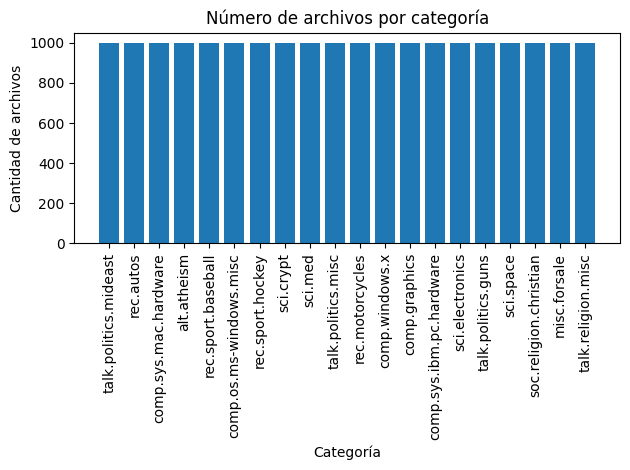

In [14]:
categorias = list(directorios.keys())
num_archivos = [len(os.listdir(directorios[c])) for c in categorias]

plt.bar(categorias, num_archivos)
plt.xticks(rotation=90)
plt.title("Número de archivos por categoría")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de archivos")
plt.tight_layout()
plt.show()

<p>Vamos a aplicar spacy a todos los archivos que tenemos en el dataset original. Tambien, vamos a crear un dataset en pandas con las columnas id, categoría, texto plano y texto con spacy para cada uno de los textos del datset, con este, podremos entrenar de manera mucho más sencilla nuestros modelos así como podremos hacer un EDA de manera mucho más sencilla. </p>

In [15]:
print(categorias)

['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc']


In [191]:
print(len(categorias))

20


In [40]:
# Create an empty list to store all records
dataset = []
id_counter = 0

# Iterate through each directory and its files
for dirname in tqdm(categorias):
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    
    for fname in fnames:
        # Create unique identifier
        id_counter += 1
        
        # Get file path and read content
        fpath = dirpath / fname
        try:
            with open(fpath, encoding="latin-1") as f:
                # read file content
                text_plain = f.read()
                
                # Add record to dataset
                dataset.append({
                    'id': id_counter,
                    'category': dirname,
                    'text_plain': text_plain
                })
        except Exception as e:
            print(f"Error processing file {fpath}: {e}")

# Convert to DataFrame
df_dataset = pd.DataFrame(dataset)

# Display basic information about the dataset
print("\nDataset shape:", df_dataset.shape)

100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Dataset shape: (19997, 3)


In [41]:
# Asumiendo que df_dataset ya existe y contiene la columna 'text_plain':
df_dataset['text_spacy'] = df_dataset['text_plain'].apply(nlp)
print("Se ha aplicado spaCy correctamente a la columna 'text_plain'.")

Se ha aplicado spaCy correctamente a la columna 'text_plain'.


In [43]:
def serialize_doc(doc):
    return json.dumps(doc.to_json())

In [47]:
with open('text_spacy.pkl', 'wb') as f:
    pickle.dump(df_dataset['text_spacy'].tolist(), f)

In [48]:
df_dataset.drop(columns=['text_spacy']).to_csv('newsgroup_dataset_without_spacy.csv', index=False)

In [50]:
with open('text_spacy.pkl', 'rb') as f:
    text_spacy = pickle.load(f)

In [51]:
df_dataset = pd.read_csv('newsgroup_dataset_without_spacy.csv')

In [52]:
df_dataset['text_spacy'] = text_spacy

print("Se ha cargado y deserializado el dataset correctamente.")

Se ha cargado y deserializado el dataset correctamente.


In [53]:
df_dataset.head()

,id,category,text_plain,text_spacy
0,1,talk.politics.mideast,Newsgroups: talk.politics.mideast\nPath: canta...,"(Newsgroups, :, talk.politics.mideast, \n, Pat..."
1,2,talk.politics.mideast,Xref: cantaloupe.srv.cs.cmu.edu talk.politics....,"(Xref, :, cantaloupe.srv.cs.cmu.edu, talk.poli..."
2,3,talk.politics.mideast,Xref: cantaloupe.srv.cs.cmu.edu talk.politics....,"(Xref, :, cantaloupe.srv.cs.cmu.edu, talk.poli..."
3,4,talk.politics.mideast,Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv....,"(Path, :, cantaloupe.srv.cs.cmu.edu!crabapple...."
4,5,talk.politics.mideast,Xref: cantaloupe.srv.cs.cmu.edu soc.culture.ar...,"(Xref, :, cantaloupe.srv.cs.cmu.edu, soc.cultu..."


In [54]:
# Display unique categories and their counts
unique_categories = df_dataset['category'].unique()
print("Unique categories in the dataset:")
print(len(unique_categories))

Unique categories in the dataset:
20


<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">ACTIVIDAD 1</span>

In [70]:
num_files = 15
total_tokens = 0
for i in range(num_files):
    doc = nlp(pathlib.Path(data_dir_graphics / fnames[i+300]).read_text(encoding="latin-1"))
    total_tokens += len(doc)
average_tokens = total_tokens / num_files
print("Número promedio de tokens:", average_tokens)

Número promedio de tokens: 277.93333333333334


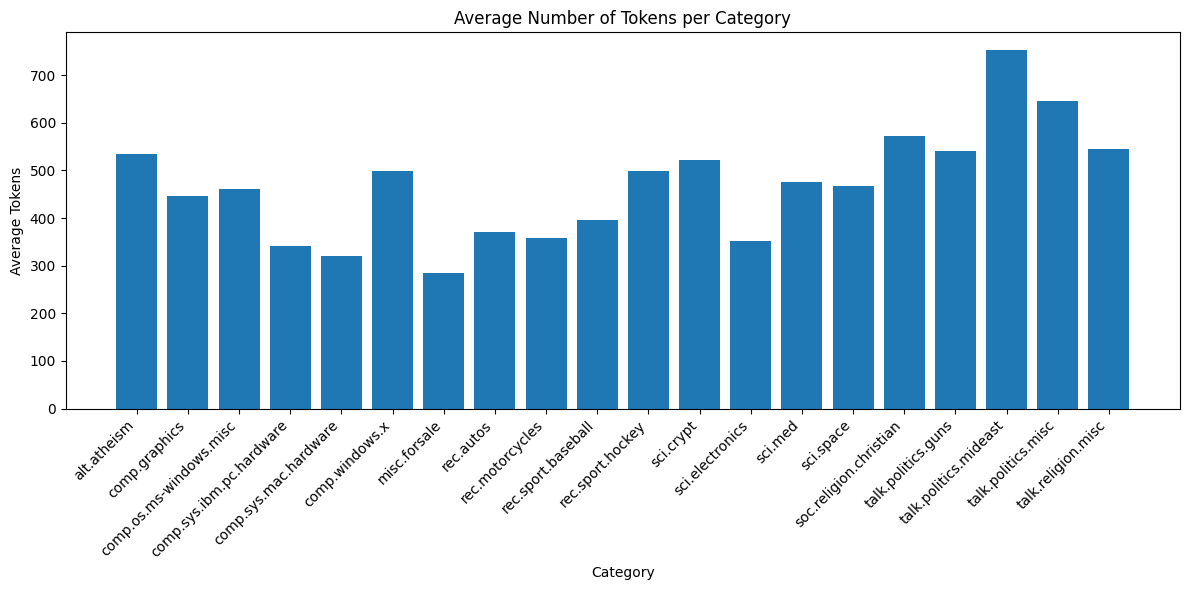

In [64]:
# Calculate the number of tokens for each text using spaCy
df_dataset['token_count'] = df_dataset['text_spacy'].apply(len)

# Calculate average tokens per category
token_count_by_category = df_dataset.groupby('category')['token_count'].mean()

# Visualize the results
plt.figure(figsize=(12,6))
plt.bar(token_count_by_category.index, token_count_by_category.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Number of Tokens per Category')
plt.xlabel('Category')
plt.ylabel('Average Tokens')
plt.tight_layout()
plt.show()

In [71]:
print(f"Average tokens for comp.graphics category: {token_count_by_category['comp.graphics']}")

Average tokens for comp.graphics category: 447.02


In [65]:
# Calculate the mean of all token counts
average_tokens_all = df_dataset['token_count'].mean()

print(f"Número promedio de tokens en todo el dataset: {average_tokens_all:.2f}")

Número promedio de tokens en todo el dataset: 469.13


In [58]:
# Calcular el número de caracteres de cada texto directamente desde df_dataset
df_dataset['char_count'] = df_dataset['text_plain'].apply(len)

# Agrupar por categoría y obtener el promedio de caracteres
char_count_by_category = df_dataset.groupby('category')['char_count'].mean()

In [60]:
# Get average character count for comp.graphics category
avg_graphics = char_count_by_category['comp.graphics']
print(f"Average number of characters in comp.graphics category: {avg_graphics:.2f}")

Average number of characters in comp.graphics category: 2177.68


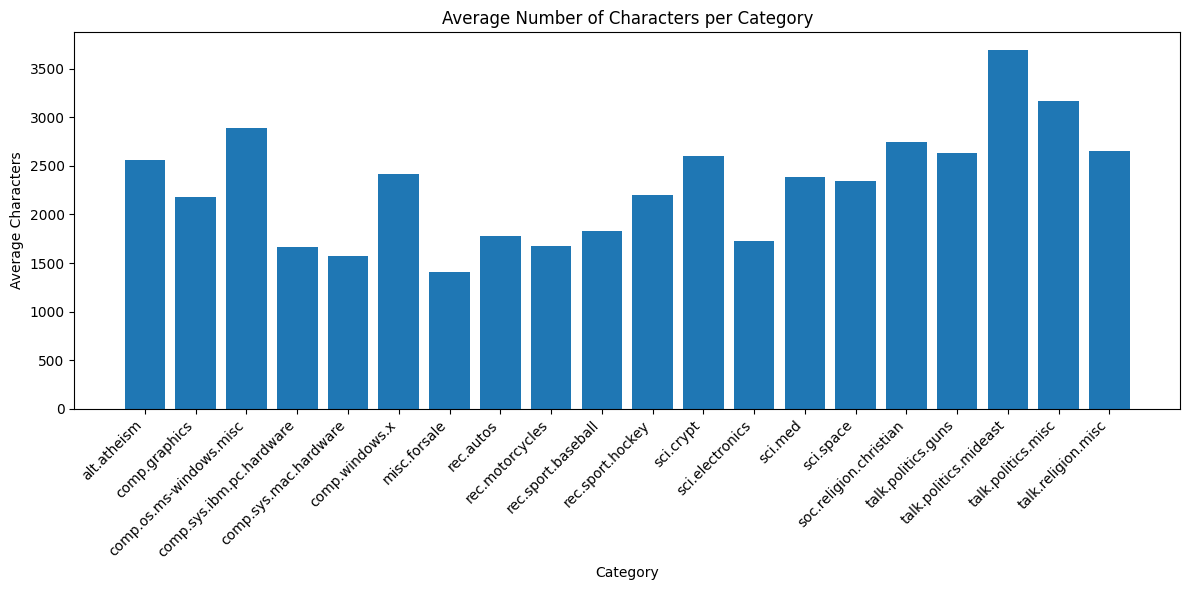

In [59]:
plt.figure(figsize=(12,6))
plt.bar(char_count_by_category.index, char_count_by_category.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Number of Characters per Category')
plt.xlabel('Category')
plt.ylabel('Average Characters')
plt.tight_layout()
plt.show()

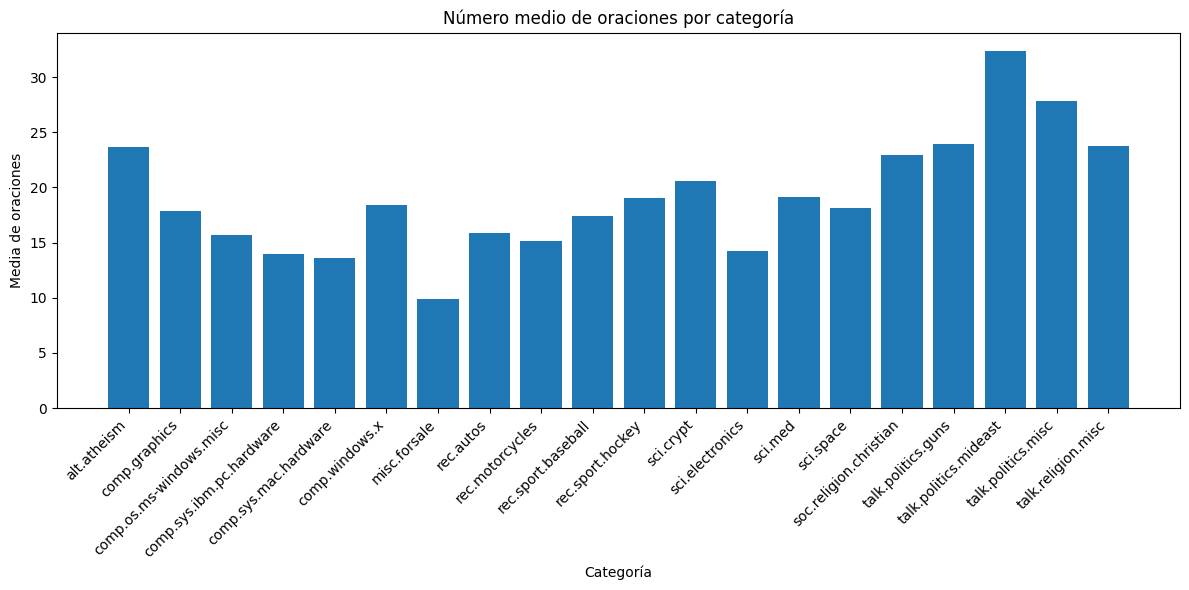

category
alt.atheism                 23.714000
comp.graphics               17.907000
comp.os.ms-windows.misc     15.708000
comp.sys.ibm.pc.hardware    13.989000
comp.sys.mac.hardware       13.567000
comp.windows.x              18.428000
misc.forsale                 9.891000
rec.autos                   15.913000
rec.motorcycles             15.121000
rec.sport.baseball          17.452000
rec.sport.hockey            19.068000
sci.crypt                   20.597000
sci.electronics             14.270000
sci.med                     19.118000
sci.space                   18.183000
soc.religion.christian      22.974925
talk.politics.guns          23.899000
talk.politics.mideast       32.399000
talk.politics.misc          27.858000
talk.religion.misc          23.768000
Name: num_sentences, dtype: float64


In [72]:
# Creamos la columna con el número de oraciones en cada texto
df_dataset["num_sentences"] = df_dataset["text_spacy"].apply(lambda doc: len(list(doc.sents)))

# Calculamos la media de oraciones por categoría
sentence_count_by_category = df_dataset.groupby("category")["num_sentences"].mean()

# Visualizamos los resultados
plt.figure(figsize=(12, 6))
plt.bar(sentence_count_by_category.index, sentence_count_by_category.values)
plt.xticks(rotation=45, ha='right')
plt.title("Número medio de oraciones por categoría")
plt.xlabel("Categoría")
plt.ylabel("Media de oraciones")
plt.tight_layout()
plt.show()

print(sentence_count_by_category)

In [74]:
# Seleccionar sólo ciertas clases
list_all_dir = [
    'alt.atheism',
    'comp.graphics',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.misc',
    'talk.religion.misc'
]

In [75]:
#Algunos archivos de la categoria "talk.politics.misc"
fnames = os.listdir(data_dir / "talk.politics.misc")
print("Number of files in talk.politics.misc:", len(fnames))
print("Some example filenames:", fnames[:5])

Number of files in talk.politics.misc: 1000
Some example filenames: ['178529', '178971', '178985', '178340', '178516']


In [76]:
#Ejemplo de un texto de la categoría "talk.politics.misc"
print(open(data_dir / "talk.politics.misc" / "178463").read())

Xref: cantaloupe.srv.cs.cmu.edu talk.politics.guns:54219 talk.politics.misc:178463
Newsgroups: talk.politics.guns,talk.politics.misc
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!darwin.sura.net!martha.utcc.utk.edu!FRANKENSTEIN.CE.UTK.EDU!VEAL
From: VEAL@utkvm1.utk.edu (David Veal)
Subject: Re: Proof of the Viability of Gun Control
Message-ID: <VEAL.749.735192116@utkvm1.utk.edu>
Lines: 21
Sender: usenet@martha.utcc.utk.edu (USENET News System)
Organization: University of Tennessee Division of Continuing Education
References: <1qpbqd$ntl@access.digex.net> <C5otvp.ItL@magpie.linknet.com>
Date: Mon, 19 Apr 1993 04:01:56 GMT

[alt.drugs and alt.conspiracy removed from newsgroups line.]

In article <C5otvp.ItL@magpie.linknet.com> neal@magpie.linknet.com (Neal) writes:

>   Once the National Guard has been called into federal service,
>it is under the command of the present. Tha N

<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">ACTIVIDAD 2</span>

In [77]:
samples = []
labels = []
class_names = []
class_index = 0
for dirname in list_all_dir:
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))

Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.misc', 'talk.religion.misc']
Number of samples: 14997


# Mezclando los datos para separarlos en Traning y Test

<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">ACTIVIDAD 3</span>

In [78]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)
keras.utils.set_random_seed(seed)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">ACTIVIDAD 4</span>


In [79]:
print(train_samples[:3])

['Summary: Interesting idea from Russia!\nMessage-ID: <AAFkHthmj4@aoibs.msk.su>\nLines: 18\n\n\n        Dear gentlemen!\n\nThe firm called "INTERBUSINESS,LTD" offers quite inexpensive\nmethod to determine ore & oil locations all over the world.\nIn this method used data got from space satellites. Being\nin your office and using theese data you can get a good statis-\ntical prognosis of locations mentioned above.\n\n        This prognosis could be done for any part of the world!\nIf you\'re interested in details please send E-mail:\n\n        svn@aoibs.msk.su\n\n        Sushkov Vladimir,\n        Moscow, Russia.\n\n\n', '\nIn article <C5HKv2.Epv@blaze.cs.jhu.edu> arromdee@jyusenkyou.cs.jhu.edu (Ken Arromdee) writes:\n\n>In article <115256@bu.edu> jaeger@buphy.bu.edu (Gregg Jaeger) writes:\n\n>>Judaism, for one. Maddi has confirmed this for one. And again I\n>>reiterate that one can easily leave the religion at any time,\n>>simply by making a public declaration. If one is too lazy to do\

In [80]:
print(val_samples[:1])

["NNTP-Posting-Host: g215a-1.nextwork.rose-hulman.edu\n\nIn article <93122@hydra.gatech.EDU> re4@prism.gatech.EDU (RUSSELL EARNEST)  \nwrites:\n> This brings back the long suffering memories of pre-chop Braves fans who\n> kept being promised the Bob Horner - Dale Murphy back to back power slam.  \n> Who could stop that?  Guess we'll never know.\n\nWhy not? Horner played 130 games in 1985 and hit 27 HR.\nMurphy played 162 and hit 37.\nIn 1986 Horner hit 27 in 141 games and Murphy hit 29 in 160 games.\n(and the Braves lost 96 and 89 games).\n\njohn rickert\nrickert@nextwork.rose-hulman.edu\n"]


In [81]:
print(train_labels[:1])

[10]


In [82]:
print(val_labels[:1])

[6]


<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">SPLIT Y ENCODING SENCILLO</span>
<p>Para realizar esta parte, haremos uso del dataset que hemos creado anteriormente. Primero, haremos un preprocesado para eliminar las primeras línas del texto. Dejamos el análisis de spacy como está porque esa información no nos servirá para el entrenamiento pero sí que nos puede resultar útil para el estudio de los datos, por tanto, no se eliminará de la parte de spacy. Posteriormente, realizaremos un split usando train_test_split y posteriormente encodearemos las labels de nuestro dataset usando LabelEncoder.</p>

In [114]:
# Remove headers from text_plain column
df_dataset['text_plain_processed'] = df_dataset['text_plain'].apply(lambda x: '\n'.join(x.split('\n')[10:]))

# Print a sample to verify
print("Original text (first 200 characters):")
print(df_dataset['text_plain'].iloc[0][:200])
print("\nProcessed text (first 200 characters):")
print(df_dataset['text_plain_processed'].iloc[0][:200])

Original text (first 200 characters):
Newsgroups: talk.politics.mideast
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!brunix!d

Processed text (first 200 characters):
Lines: 24

In article <1993Apr14.125813.21737@ncsu.edu> hernlem@chess.ncsu.edu (Brad Hernlem) writes:

   Lebanese resistance forces detonated a bomb under an Israeli occupation
   patrol in Lebanese 


In [153]:

# Encode the categories
label_encoder = LabelEncoder()
df_dataset['category_encoded'] = label_encoder.fit_transform(df_dataset['category'])

# Split the data
X = df_dataset['text_plain_processed']
y = df_dataset['category_encoded']

# Create train/test split with the same random seed used before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=1337)

# Print some information about the split
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nUnique categories: {len(label_encoder.classes_)}")
print("\nCategory mapping:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category} -> {i}")

Training samples: 15997
Test samples: 4000

Unique categories: 20

Category mapping:
alt.atheism -> 0
comp.graphics -> 1
comp.os.ms-windows.misc -> 2
comp.sys.ibm.pc.hardware -> 3
comp.sys.mac.hardware -> 4
comp.windows.x -> 5
misc.forsale -> 6
rec.autos -> 7
rec.motorcycles -> 8
rec.sport.baseball -> 9
rec.sport.hockey -> 10
sci.crypt -> 11
sci.electronics -> 12
sci.med -> 13
sci.space -> 14
soc.religion.christian -> 15
talk.politics.guns -> 16
talk.politics.mideast -> 17
talk.politics.misc -> 18
talk.religion.misc -> 19


In [154]:
# Print training and test sizes
print("Training Data:")
print(f"Number of training samples: {len(X_train)}")
print(f"Number of training labels: {len(y_train)}")
print("\nTest Data:")
print(f"Number of test samples: {len(X_test)}")
print(f"Number of test labels: {len(y_test)}")

Training Data:
Number of training samples: 15997
Number of training labels: 15997

Test Data:
Number of test samples: 4000
Number of test labels: 4000


In [155]:
x_val = X_test

In [156]:
y_val = y_test

In [121]:
print("\nTest Data:")
print(f"Number of test samples: {len(x_val)}")
print(f"Number of test labels: {len(y_val)}")


Test Data:
Number of test samples: 4000
Number of test labels: 4000


# Tokenización de las palabras con TextVectorization

<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">ACTIVIDAD 5</span>

In [157]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

2025-02-08 08:02:55.663322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [123]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'to', 'of']

In [124]:
len(vectorizer.get_vocabulary())

20000

# Viendo la salida de Vectorizer

In [125]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([   2, 3844, 2060,   18,    2, 4807])

In [126]:
output

<tf.Tensor: shape=(1, 200), dtype=int64, numpy=
array([[   2, 3844, 2060,   18,    2, 4807,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [127]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [128]:
test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[2, 3844, 2060, 18, 2, 4807]

# Tokenización de los datos de entrenamiento y validación

In [158]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_val = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_val = np.array(y_test)

In [159]:
x_train.shape

(15997, 200)

In [160]:
y_train.shape

(15997,)

In [161]:
x_val.shape

(4000, 200)

In [162]:
y_val.shape

(4000,)

In [163]:
# Create new vectorizer with output length 400
vectorizer_400 = TextVectorization(max_tokens=20000, output_sequence_length=400)

# Create text dataset from X_train
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer_400.adapt(text_ds)

# Create new vectorized training and test sets
x_train_400 = vectorizer_400(np.array([[s] for s in X_train])).numpy()
x_test_400 = vectorizer_400(np.array([[s] for s in X_test])).numpy()

# Print shapes to verify the new sequence length
print("New training set shape:", x_train_400.shape)
print("New test set shape:", x_test_400.shape)

2025-02-08 08:03:34.284737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


New training set shape: (15997, 400)
New test set shape: (4000, 400)


In [150]:
x_train_400.shape

(15997, 400)

In [151]:
x_test_400.shape

(4000, 400)

# Creación y entrenamiento del modelo

In [170]:
# Create the model
model = models.Sequential([
    # Embedding layer for text processing
    layers.Embedding(input_dim=20000, output_dim=128, input_length=200),
    
    # Add bidirectional LSTM layer
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    
    # Add global max pooling
    layers.GlobalMaxPooling1D(),
    
    # Add dense layers with dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    
    # Output layer with 15 classes (number of unique categories)
    layers.Dense(20, activation='softmax')
])

/opt/anaconda3/envs/actividad2_NLP/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [171]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [172]:
# Print model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [173]:
# Train the model
history_200 = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 163ms/step - accuracy: 0.0626 - loss: 2.9710 - val_accuracy: 0.1772 - val_loss: 2.4298
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 143ms/step - accuracy: 0.1750 - loss: 2.3789 - val_accuracy: 0.3890 - val_loss: 1.6077
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 144ms/step - accuracy: 0.3417 - loss: 1.7295 - val_accuracy: 0.4655 - val_loss: 1.3322
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.4244 - loss: 1.4195 - val_accuracy: 0.5290 - val_loss: 1.2125
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 135ms/step - accuracy: 0.4978 - loss: 1.2062 - val_accuracy: 0.6040 - val_loss: 1.1412
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.5666 - loss: 1.0681 - val_accuracy: 0.6662 - val_loss: 1.0506
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 137ms/step - accuracy: 0.6276 - loss: 0.9292 - val_accuracy: 0.6840 - val_loss: 1.0510
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 132ms/step - accuracy: 0.6703 - loss: 0

In [164]:
# Create the model for 400-length sequences
model_400 = models.Sequential([
    # Embedding layer for text processing
    layers.Embedding(input_dim=20000, output_dim=128, input_length=400),
    
    # Add bidirectional LSTM layer
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    
    # Add global max pooling
    layers.GlobalMaxPooling1D(),
    
    # Add dense layers with dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    
    # Output layer with 20 classes (number of unique categories)
    layers.Dense(20, activation='softmax')
])

# Compile the model
model_400.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_400 = model_400.fit(
    x_train_400,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_test_400, y_test),
    verbose=1
)

/opt/anaconda3/envs/actividad2_NLP/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 123s 234ms/step - accuracy: 0.0583 - loss: 2.9690 - val_accuracy: 0.1427 - val_loss: 2.4343
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 224ms/step - accuracy: 0.1716 - loss: 2.3693 - val_accuracy: 0.4132 - val_loss: 1.6622
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 224ms/step - accuracy: 0.3572 - loss: 1.7634 - val_accuracy: 0.5263 - val_loss: 1.3306
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 112s 224ms/step - accuracy: 0.4733 - loss: 1.4038 - val_accuracy: 0.6283 - val_loss: 1.1196
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 109s 219ms/step - accuracy: 0.5655 - loss: 1.1810 - val_accuracy: 0.6737 - val_loss: 1.0354
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 215ms/step - accuracy: 0.6291 - loss: 1.0288 - val_accuracy: 0.7258 - val_loss: 0.9246
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 215ms/step - accuracy: 0.6742 - loss: 0.9025 - val_accuracy: 0.7465 - val_loss: 0.9160
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 108s 215ms/step - accuracy: 0.7261 -

# Evaluación

<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">ACTIVIDAD 6</span>

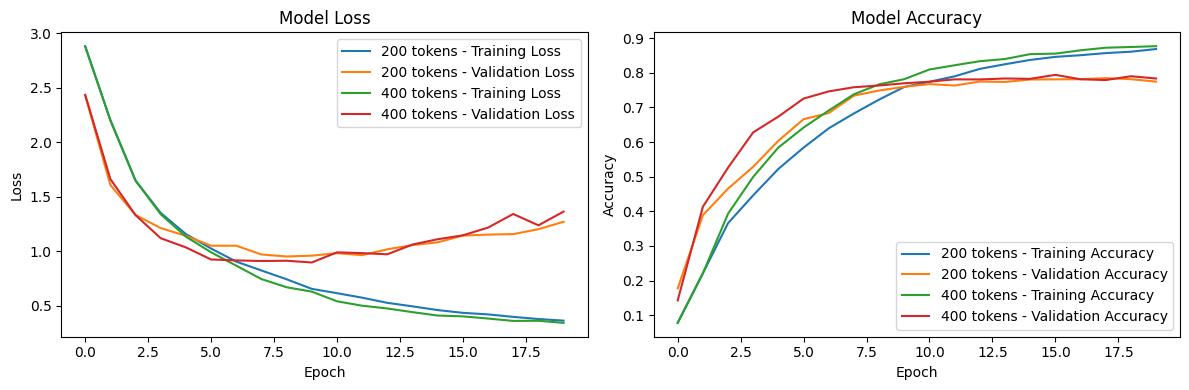

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step


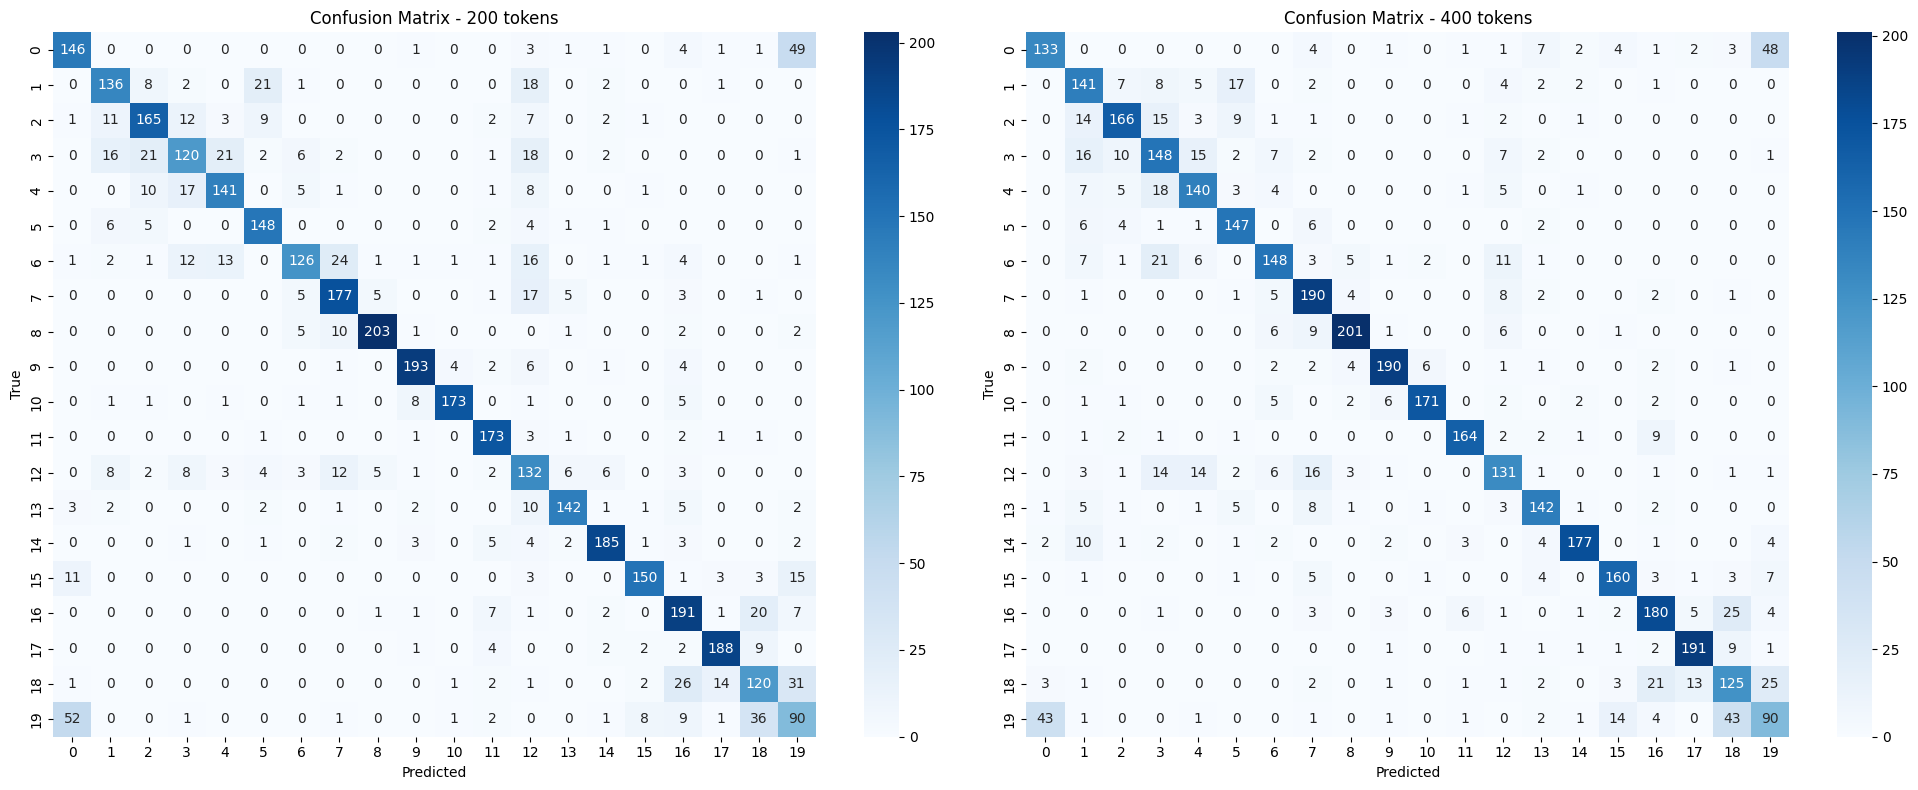

Classification Report - 200 tokens model:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69       207
           1       0.75      0.72      0.73       189
           2       0.77      0.77      0.77       213
           3       0.69      0.57      0.63       210
           4       0.77      0.77      0.77       184
           5       0.79      0.89      0.83       167
           6       0.83      0.61      0.70       206
           7       0.76      0.83      0.79       214
           8       0.94      0.91      0.92       224
           9       0.91      0.91      0.91       211
          10       0.96      0.90      0.93       192
          11       0.84      0.95      0.89       183
          12       0.52      0.68      0.59       195
          13       0.89      0.83      0.86       171
          14       0.89      0.89      0.89       209
          15       0.90      0.81      0.85       186
          16       0.72      0.83      

In [174]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot training history for both models
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_200.history['loss'], label='200 tokens - Training Loss')
plt.plot(history_200.history['val_loss'], label='200 tokens - Validation Loss')
plt.plot(history_400.history['loss'], label='400 tokens - Training Loss')
plt.plot(history_400.history['val_loss'], label='400 tokens - Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_200.history['accuracy'], label='200 tokens - Training Accuracy')
plt.plot(history_200.history['val_accuracy'], label='200 tokens - Validation Accuracy')
plt.plot(history_400.history['accuracy'], label='400 tokens - Training Accuracy')
plt.plot(history_400.history['val_accuracy'], label='400 tokens - Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate confusion matrices

# Predictions for 200 tokens model
y_pred_200 = model.predict(x_val)
y_pred_classes_200 = np.argmax(y_pred_200, axis=1)

# Predictions for 400 tokens model 
y_pred_400 = model_400.predict(x_test_400)
y_pred_classes_400 = np.argmax(y_pred_400, axis=1)

# Plot confusion matrices
plt.figure(figsize=(20, 8))

# 200 tokens confusion matrix
plt.subplot(1, 2, 1)
cm_200 = confusion_matrix(y_val, y_pred_classes_200)
sns.heatmap(cm_200, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - 200 tokens')
plt.xlabel('Predicted')
plt.ylabel('True')

# 400 tokens confusion matrix  
plt.subplot(1, 2, 2)
cm_400 = confusion_matrix(y_test, y_pred_classes_400)
sns.heatmap(cm_400, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - 400 tokens')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Print classification reports
print("Classification Report - 200 tokens model:")
print(classification_report(y_val, y_pred_classes_200))

print("\nClassification Report - 400 tokens model:")
print(classification_report(y_test, y_pred_classes_400))

# Calculate and print final metrics
final_train_acc_200 = history_200.history['accuracy'][-1]
final_val_acc_200 = history_200.history['val_accuracy'][-1]
final_train_acc_400 = history_400.history['accuracy'][-1]
final_val_acc_400 = history_400.history['val_accuracy'][-1]

print("\nFinal Metrics:")
print("200 tokens model:")
print(f"Training Accuracy: {final_train_acc_200:.4f}")
print(f"Validation Accuracy: {final_val_acc_200:.4f}")
print("\n400 tokens model:")
print(f"Training Accuracy: {final_train_acc_400:.4f}")
print(f"Validation Accuracy: {final_val_acc_400:.4f}")

<span style="font-size: 15pt; font-weight: bold; color: #0098cd;">ACTIVIDAD 7</span>

In [194]:
# Ajusta 'vectorizer' con el que corresponda a tus modelos
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)

# Ajusta 'model_200' y 'model_400' a los nombres reales de tus modelos 
preds_200 = modeloClasico(x)
end_to_end_model_200 = keras.Model(string_input, preds_200)

preds_400 = modeloTransformers(x)
end_to_end_model_400 = keras.Model(string_input, preds_400)

# Textos a probar
test_texts = [
    ["this message is about computer graphics and 3D modeling"],
    ["politics and federal courts law that people understand with politician and elects congressman"],
    ["we are talking about religion"]
]

# Imprimir resultados
for text in test_texts:
    probabilities_200 = end_to_end_model_200(keras.ops.convert_to_tensor(text))
    probabilities_400 = end_to_end_model_400(keras.ops.convert_to_tensor(text))

    print(f"Texto: {text[0]}")
    print(
        "Predicción Modelo 200:", 
        categorias[np.argmax(probabilities_200[0])]
    )
    print(
        "Predicción Modelo 400:", 
        categorias[np.argmax(probabilities_400[0])]
    )
    print()

Texto: this message is about computer graphics and 3D modeling
Predicción Modelo 200: rec.autos
Predicción Modelo 400: rec.autos

Texto: politics and federal courts law that people understand with politician and elects congressman
Predicción Modelo 200: talk.religion.misc
Predicción Modelo 400: sci.space

Texto: we are talking about religion
Predicción Modelo 200: talk.politics.mideast
Predicción Modelo 400: talk.politics.mideast



<h1>SECCIÓN EXTRA, ENTRENAMIENTO DE LOS MODELOS DE RED NEURONAL CLÁSICA Y CON TRANSFORMERS CON LOS DATOS COMPLETOS</h1>

In [166]:
# Create the classic model
modeloClasico = keras.models.Sequential([
    # Embedding layer with 20000 vocabulary size (same as vectorizer), 10 dimensions
    keras.layers.Embedding(20000, 10, input_length=200),
    
    # Flatten the 3D tensor output from Embedding into 2D tensor
    keras.layers.Flatten(),
    
    # Dense layer with 512 units and ReLU activation
    keras.layers.Dense(512, activation='relu'),
    
    # Dropout for regularization
    keras.layers.Dropout(0.3),
    
    # Output layer with 20 units (number of classes) and softmax activation
    keras.layers.Dense(20, activation='softmax')
])

# Compile the model
modeloClasico.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print(modeloClasico.summary())

# Train the model
history_clasico = modeloClasico.fit(
    x_train, 
    y_train,
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=1
)

/opt/anaconda3/envs/actividad2_NLP/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.0844 - loss: 2.9431 - val_accuracy: 0.1655 - val_loss: 2.6028
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2196 - loss: 2.4120 - val_accuracy: 0.2790 - val_loss: 2.1340
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4247 - loss: 1.8271 - val_accuracy: 0.3955 - val_loss: 1.7595
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5958 - loss: 1.3053 - val_accuracy: 0.4775 - val_loss: 1.5372
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7327 - loss: 0.9133 - val_accuracy: 0.5562 - val_loss: 1.3397
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8098 - loss: 0.6417 - val_accuracy: 0.5903 - val_loss: 1.2591
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8624 - loss: 0.4668 - val_accuracy: 0.6162 - val_loss: 1.2417
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8973 - loss: 0.3548 - val

In [168]:
from tensorflow.keras import layers
import tensorflow as tf

import tensorflow.keras as keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1    = layers.Dropout(rate)
        self.dropout2    = layers.Dropout(rate)

    def call(self, inputs, training):
        # Bloque de self-attention
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Bloque feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb   = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen_dynamic = tf.shape(x)[-1]  
        positions = tf.range(start=0, limit=maxlen_dynamic, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Parámetros principales 
embed_dim  = 32    
num_heads  = 2     
ff_dim     = 32    
num_tokens = len(voc) + 2  
maxlen     = 200   

# Crear modelo
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_tokens, embed_dim)

x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=False)

x = layers.GlobalAveragePooling1D()(x)

x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)  # Increased intermediate dense layer size
x = layers.Dropout(0.1)(x)

# Output layer with 20 classes
outputs = layers.Dense(20, activation="softmax")(x)  # Changed to 20 output classes

modeloTransformers = keras.Model(inputs=inputs, outputs=outputs)

modeloTransformers.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["acc"]
)

history_transformers = modeloTransformers.fit(
    x_train,
    y_train, 
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val)
)

print(modeloTransformers.summary())

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 351ms/step - acc: 0.0787 - loss: 2.9718 - val_acc: 0.1915 - val_loss: 2.7249
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step - acc: 0.1775 - loss: 2.6528 - val_acc: 0.3040 - val_loss: 2.3317
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 332ms/step - acc: 0.2990 - loss: 2.2501 - val_acc: 0.3270 - val_loss: 2.0178
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 309ms/step - acc: 0.4389 - loss: 1.7841 - val_acc: 0.5635 - val_loss: 1.3906
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - acc: 0.6515 - loss: 1.1384 - val_acc: 0.6998 - val_loss: 1.0007
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 333ms/step - acc: 0.7627 - loss: 0.7720 - val_acc: 0.7607 - val_loss: 0.7955
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 338ms/step - acc: 0.8292 - loss: 0.5707 - val_acc: 0.7785 - val_loss: 0.7664
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - acc: 0.8725 - loss: 0.4318 - val_acc: 0.7972 - val_loss: 0.7458
Epoch 9/20
125/125 ━━━━━━━━━━━━━

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_1  │ (None, 200, 32)        │       646,464 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 32)        │        10,656 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,674 (5.03 MB)

 Trainable params: 658,836 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 658,838 (2.51 MB)

None


NameError: name 'x_test' is not defined

In [169]:
s = modeloTransformers.evaluate(x_val, y_val)

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - acc: 0.7987 - loss: 1.1539


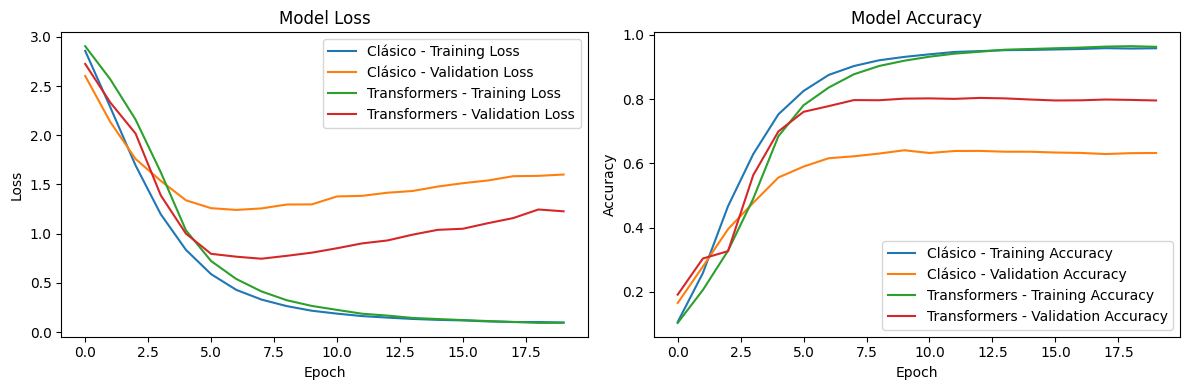

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


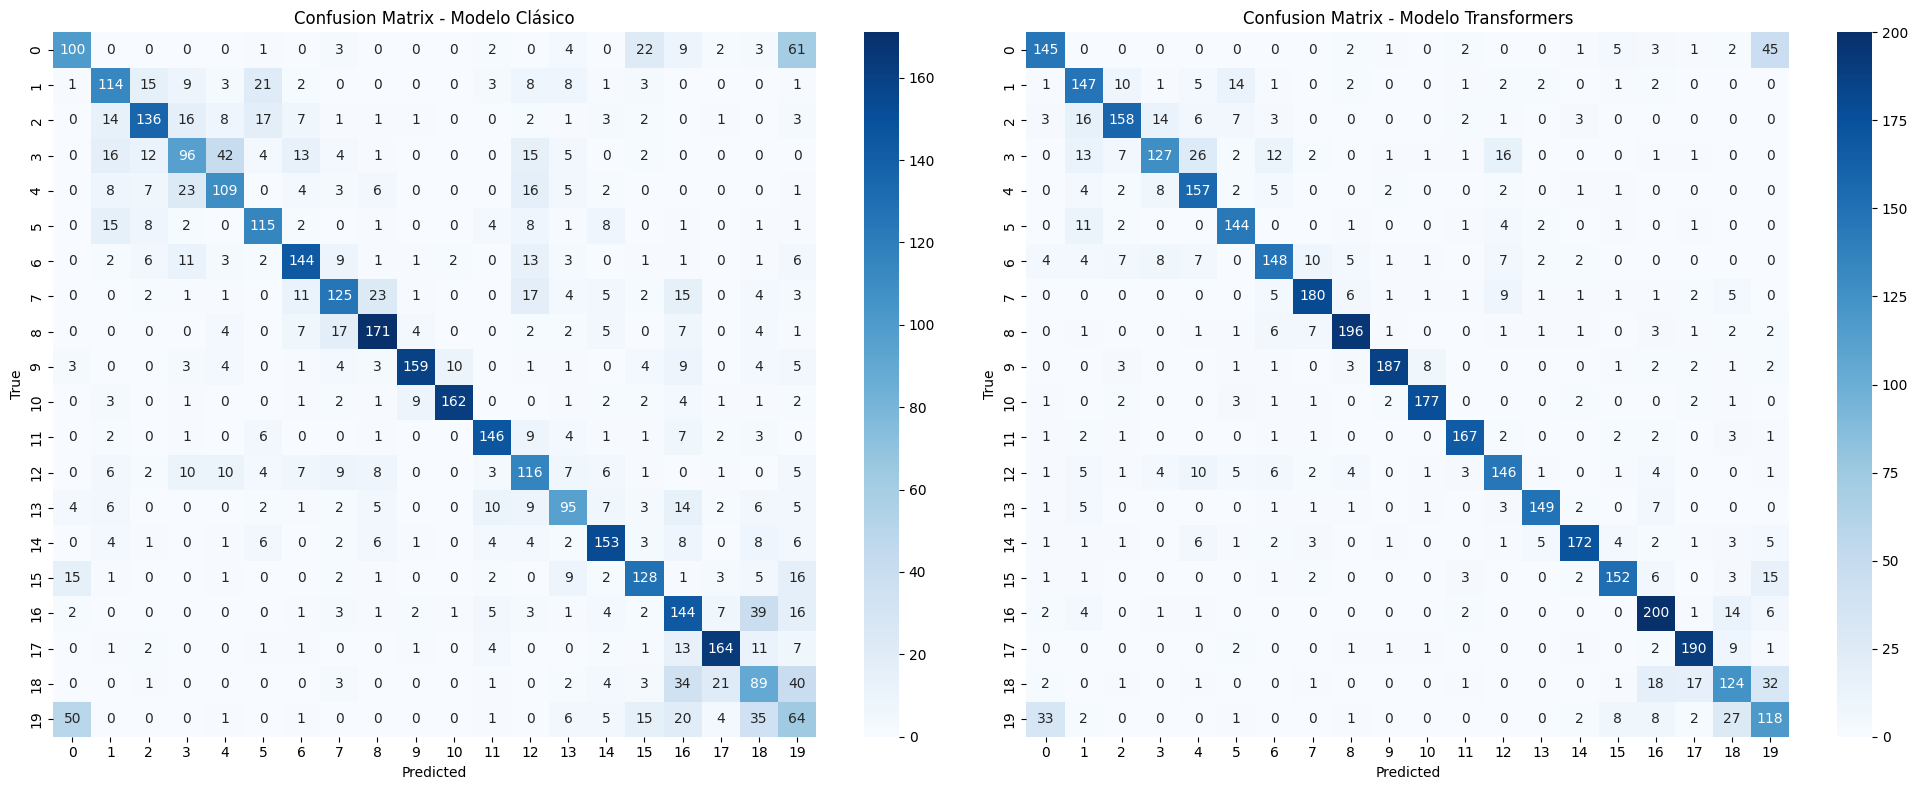

Classification Report - Modelo Clásico:
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       207
           1       0.59      0.60      0.60       189
           2       0.71      0.64      0.67       213
           3       0.55      0.46      0.50       210
           4       0.58      0.59      0.59       184
           5       0.64      0.69      0.66       167
           6       0.71      0.70      0.70       206
           7       0.66      0.58      0.62       214
           8       0.74      0.76      0.75       224
           9       0.89      0.75      0.82       211
          10       0.93      0.84      0.88       192
          11       0.79      0.80      0.79       183
          12       0.52      0.59      0.56       195
          13       0.59      0.56      0.57       171
          14       0.73      0.73      0.73       209
          15       0.66      0.69      0.67       186
          16       0.50      0.62      0.

In [185]:
# Gráficas de entrenamiento para ambos modelos
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_clasico.history['loss'], label='Clásico - Training Loss')
plt.plot(history_clasico.history['val_loss'], label='Clásico - Validation Loss')
plt.plot(history_transformers.history['loss'], label='Transformers - Training Loss')
plt.plot(history_transformers.history['val_loss'], label='Transformers - Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Exactitud
plt.subplot(1, 2, 2)
plt.plot(history_clasico.history['accuracy'], label='Clásico - Training Accuracy')
plt.plot(history_clasico.history['val_accuracy'], label='Clásico - Validation Accuracy')
plt.plot(history_transformers.history['acc'], label='Transformers - Training Accuracy')
plt.plot(history_transformers.history['val_acc'], label='Transformers - Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Predicciones del modelo clásico
y_pred_clasico = modeloClasico.predict(x_val)
y_pred_classes_clasico = np.argmax(y_pred_clasico, axis=1)

# Predicciones del modelo de transformers
y_pred_transformers = modeloTransformers.predict(x_val)
y_pred_classes_transformers = np.argmax(y_pred_transformers, axis=1)

# Matrices de confusión
plt.figure(figsize=(20, 8))

# Confusión - modelo clásico
plt.subplot(1, 2, 1)
cm_clasico = confusion_matrix(y_val, y_pred_classes_clasico)
sns.heatmap(cm_clasico, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Modelo Clásico')
plt.xlabel('Predicted')
plt.ylabel('True')

# Confusión - modelo transformers
plt.subplot(1, 2, 2)
cm_transformers = confusion_matrix(y_val, y_pred_classes_transformers)
sns.heatmap(cm_transformers, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Modelo Transformers')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

# Reportes de clasificación
print("Classification Report - Modelo Clásico:")
print(classification_report(y_val, y_pred_classes_clasico))

print("\nClassification Report - Modelo Transformers:")
print(classification_report(y_val, y_pred_classes_transformers))

# Métricas finales
final_train_acc_clasico = history_clasico.history['accuracy'][-1]
final_val_acc_clasico = history_clasico.history['val_accuracy'][-1]
final_train_acc_transformers = history_transformers.history['acc'][-1]0
final_val_acc_transformers = history_transformers.history['val_acc'][-1]

print("\nFinal Metrics:")
print("Modelo Clásico:")
print(f"Training Accuracy: {final_train_acc_clasico:.4f}")
print(f"Validation Accuracy: {final_val_acc_clasico:.4f}")

print("\nModelo Transformers:")
print(f"Training Accuracy: {final_train_acc_transformers:.4f}")
print(f"Validation Accuracy: {final_val_acc_transformers:.4f}")